In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib

import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [ ]:
df = pd.read_csv(r'C:\Users\Shubham\Desktop\Projects\Evaluation\(5)_Census\census_income.csv')

# Data Understanding

In [ ]:
df.shape

(32560, 15)

In [ ]:
pd.set_option("display.max_columns", None)
df.head() #Looking into the top 5 rows of the dataset

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [ ]:
df.info() #Basic info of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


We see that the data is a mix of object and int type. We shall convert all the object type into numerical ones so we could move ahead with the model predictions

In [ ]:
df.isnull().sum() #Checking for null values

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

We see here that there are no null values, however in this datacase the null values are represented in the form of '?' and so we shall treat it for the same.

In [ ]:
# Replacing with null values
df = df.replace(' ?',np.NaN)

In [ ]:
df.isnull().sum() #Checking for null values

Age                  0
Workclass         1836
Fnlwgt               0
Education            0
Education_num        0
Marital_status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_gain         0
Capital_loss         0
Hours_per_week       0
Native_country     583
Income               0
dtype: int64

Since, we have more than 30,000 rows of data, let us remove all the rows containing null values

In [ ]:
# Dropping all rows with null values
df_new = df.dropna()

In [ ]:
# Shape of the new dataframe
df_new.shape

(30161, 15)

In [ ]:
print('Percentage loss of data: ', ((df.shape[0]-df_new.shape[0])/df.shape[0])*100, '%')

Percentage loss of data:  7.367936117936118 %


In [ ]:
df_new.isnull().sum() #Checking for null values

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

<AxesSubplot:>

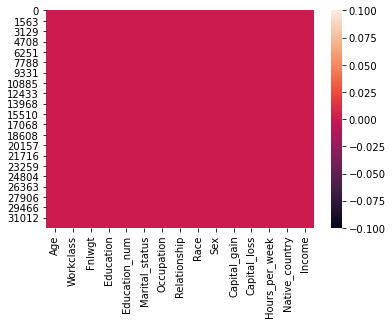

In [ ]:
sns.heatmap(df_new.isnull()) #Visualization of null values

We see that there are no null values in the dataframe

In [ ]:
df_new.describe() #Statistical evaluation of the dataset

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,30161.000000,3.016100e+04,30161.000000,30161.000000,30161.000000,30161.000000
mean,38.437883,1.897976e+05,10.121216,1091.971984,88.375419,40.931269
std,13.134882,1.056527e+05,2.549983,7406.466659,404.304753,11.980182
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176280e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784290e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376300e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
df_new.columns #Calling all the column names of the dataset

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

# Exploratory Data Analysis

Let us now look into all the columns one at a time, beginning with the target column 'Income'

In [ ]:
df_new['Income'].value_counts()

 <=50K    22653
 >50K      7508
Name: Income, dtype: int64

We see that the class in imbalanced, we shall treat for it later.We will encode the data for use for now

In [ ]:
le = LabelEncoder()
df_new['Income'] = le.fit_transform(df_new['Income'])

In [ ]:
df_new['Income'].value_counts()

0    22653
1     7508
Name: Income, dtype: int64

We have encoded
- 0 :  <=50K
- 1 :  >50K

<AxesSubplot:xlabel='Income', ylabel='count'>

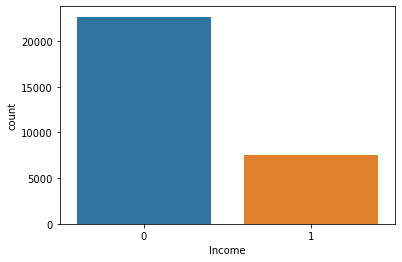

In [ ]:
# Count plot for the column
sns.countplot(df_new['Income'])

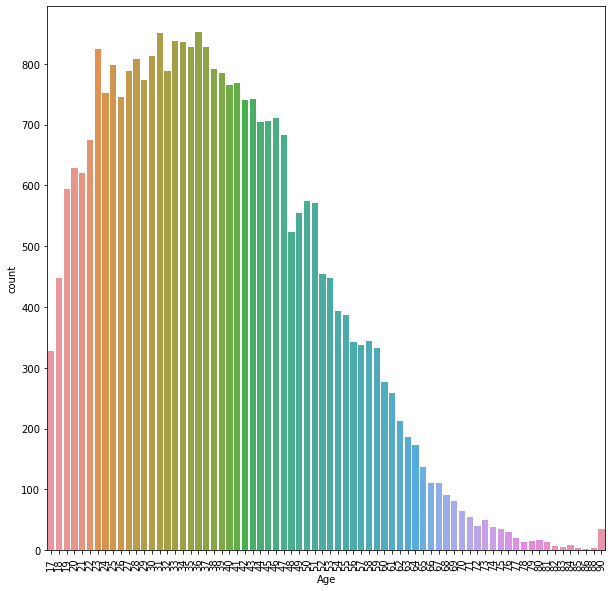

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Age'])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='Age'>

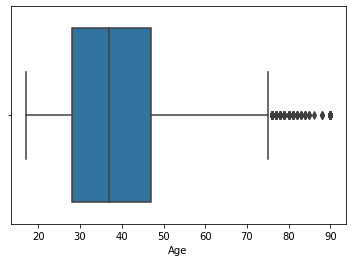

In [ ]:
# Boxplot for the column
sns.boxplot(df_new['Age'])

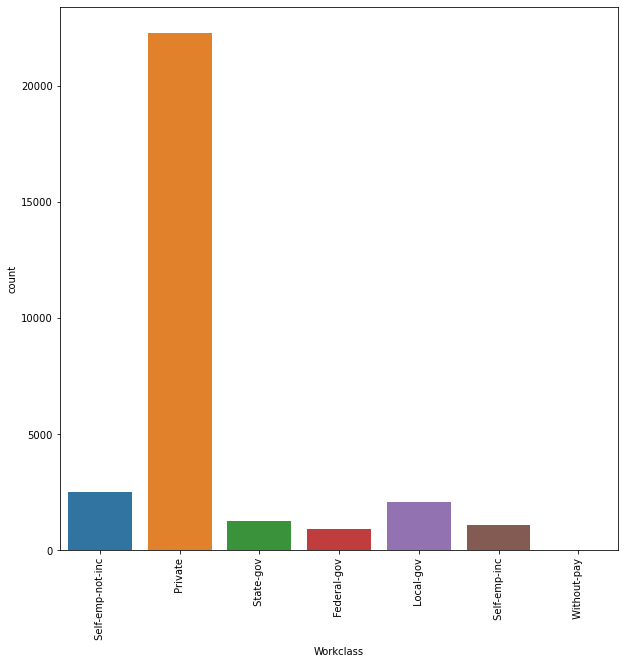

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Workclass'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_new['Workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1278
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: Workclass, dtype: int64

In [ ]:
#Encoding the data to numerical
df_new['Workclass'] = le.fit_transform(df_new['Workclass'])

<AxesSubplot:xlabel='Workclass'>

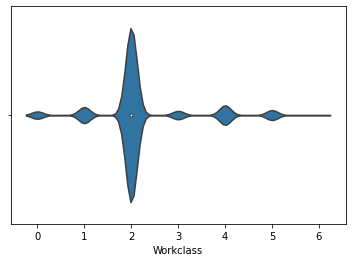

In [ ]:
# Violinplot for the column
sns.violinplot(df_new['Workclass'])

<AxesSubplot:xlabel='Fnlwgt', ylabel='Density'>

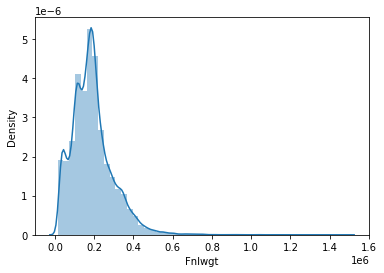

In [ ]:
#Density plot for the column
sns.distplot(df_new['Fnlwgt'])

<AxesSubplot:xlabel='Fnlwgt'>

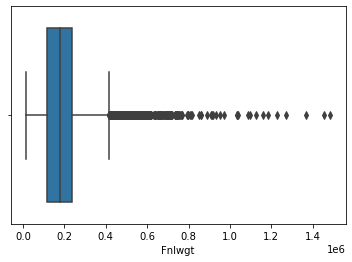

In [ ]:
# Boxplot for the column
sns.boxplot(df_new['Fnlwgt'])

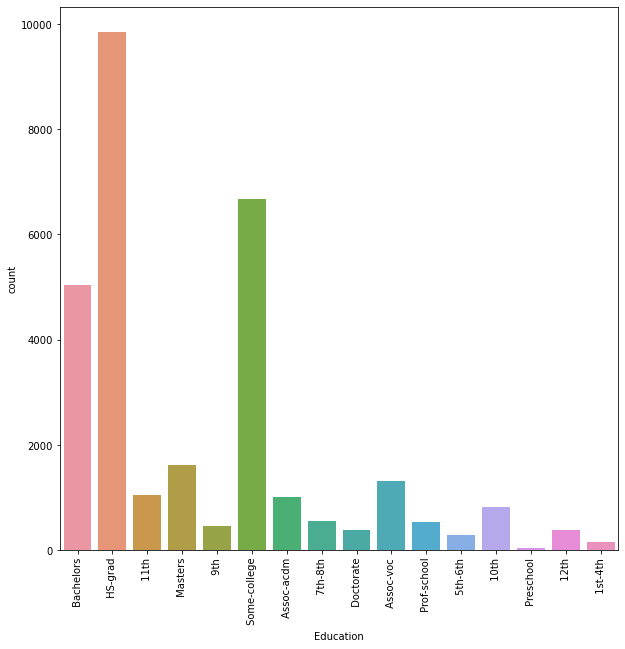

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Education'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
df_new['Education'].value_counts()

 HS-grad         9840
 Some-college    6678
 Bachelors       5043
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: Education, dtype: int64

In [ ]:

df_new['Education_num'].value_counts()

9     9840
10    6678
13    5043
14    1627
11    1307
7     1048
12    1008
6      820
4      557
15     542
5      455
8      377
16     375
3      288
2      151
1       45
Name: Education_num, dtype: int64

Since education_num column is just an encoded version of the education column, we shall drop the education column

In [ ]:
#Dropping the column
df_new = df_new.drop(columns='Education')

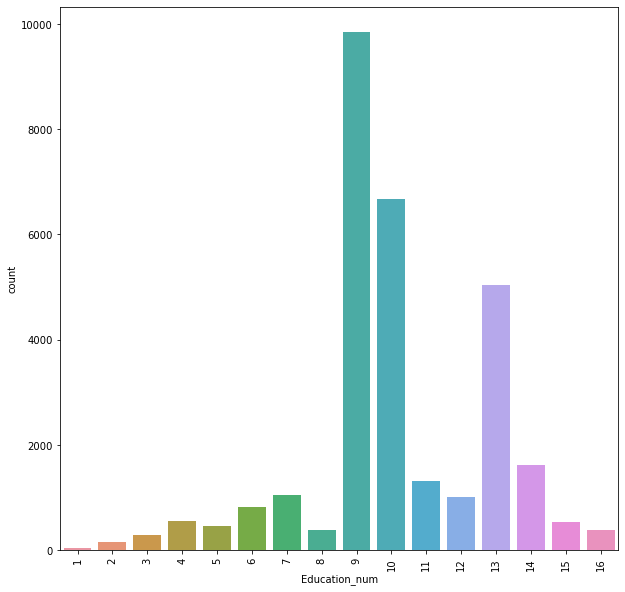

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Education_num'])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='Education_num'>

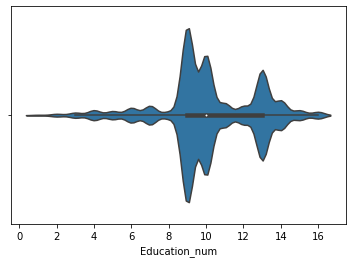

In [ ]:
#Violin plot of the column
sns.violinplot(df_new['Education_num'])

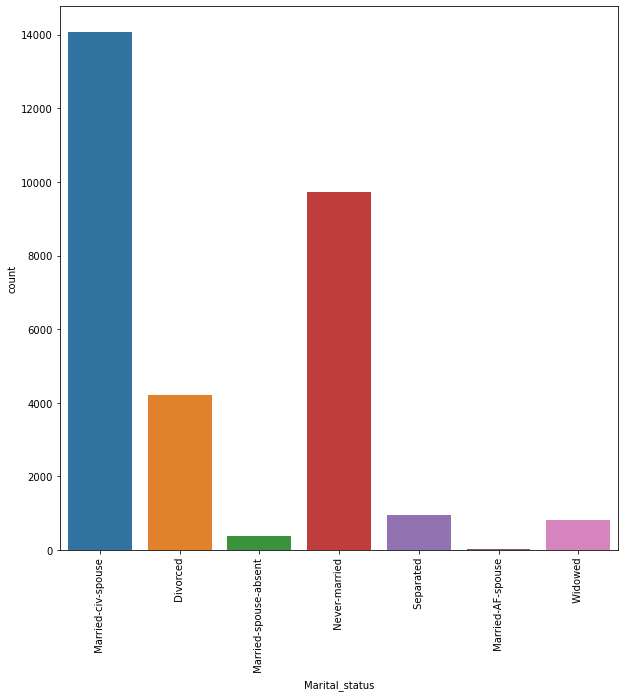

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Marital_status'])
plt.xticks(rotation=90)
plt.show()

We shall encode the data to numerical

In [ ]:
df_new['Marital_status'] = le.fit_transform(df_new['Marital_status'])

<AxesSubplot:xlabel='Marital_status'>

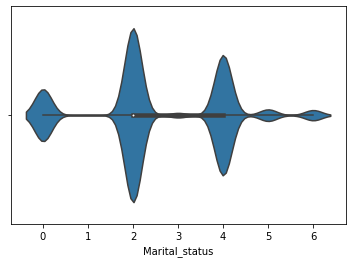

In [ ]:
#Violin plot of the column
sns.violinplot(df_new['Marital_status'])

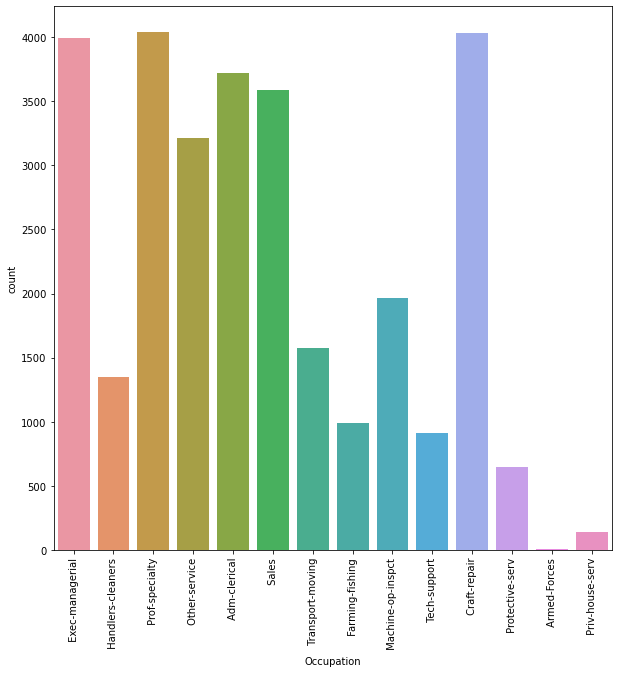

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Occupation'])
plt.xticks(rotation=90)
plt.show()

Encoding the data to numerical features

In [ ]:
df_new['Occupation'] = le.fit_transform(df_new['Occupation'])

<AxesSubplot:xlabel='Marital_status'>

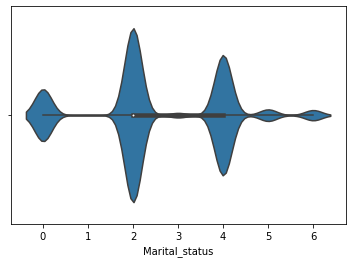

In [ ]:
#Violin plot of the column
sns.violinplot(df_new['Marital_status'])

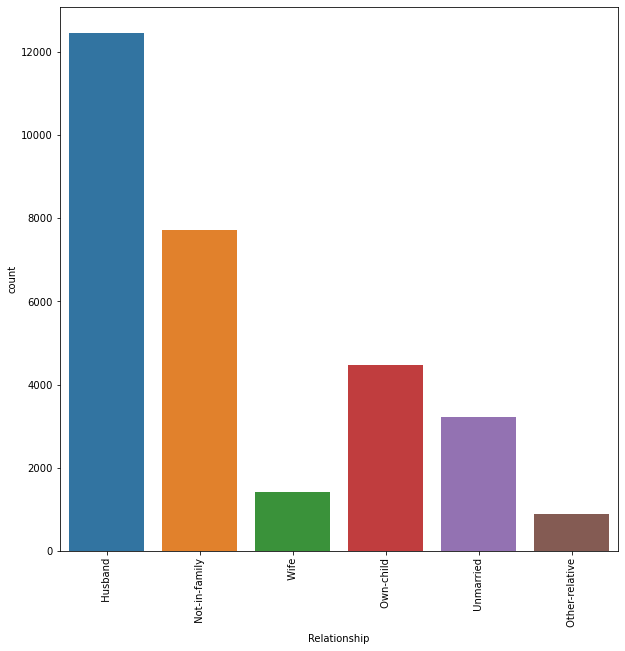

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Relationship'])
plt.xticks(rotation=90)
plt.show()

Encoding the data to numerical features

In [ ]:
df_new['Relationship'] = le.fit_transform(df_new['Relationship'])

<AxesSubplot:xlabel='Relationship'>

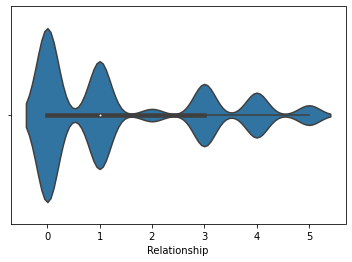

In [ ]:
#Violin plot of the column
sns.violinplot(df_new['Relationship'])

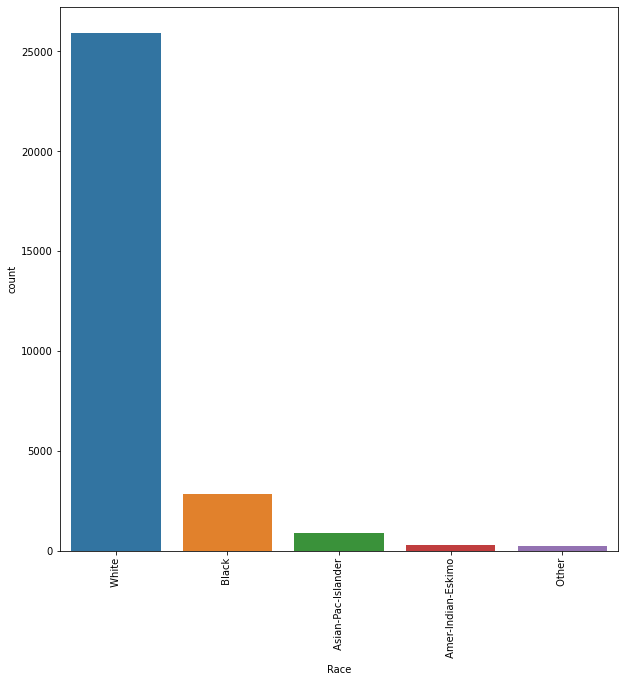

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Race'])
plt.xticks(rotation=90)
plt.show()

Encoding the data to numerical features

In [ ]:
df_new['Race'] = le.fit_transform(df_new['Race'])

<AxesSubplot:xlabel='Race'>

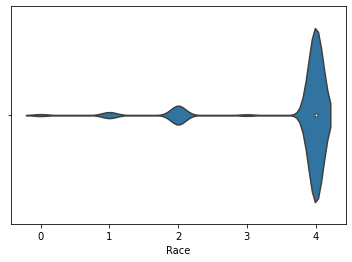

In [ ]:
#Violin plot of the column
sns.violinplot(df_new['Race'])

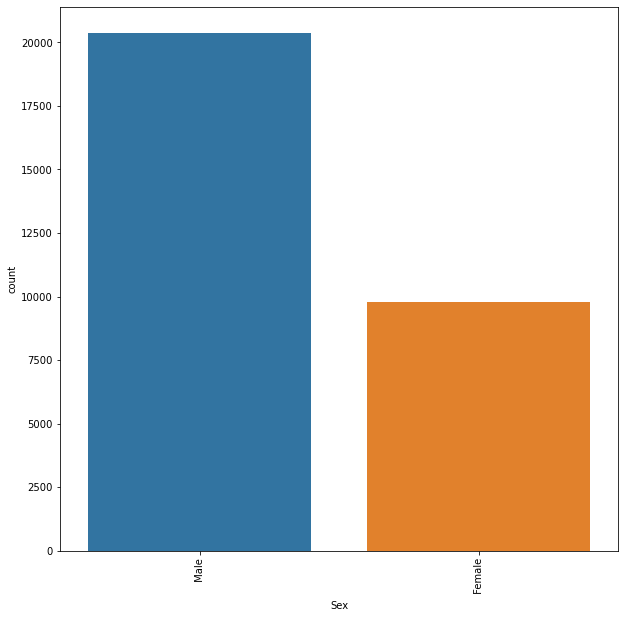

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Sex'])
plt.xticks(rotation=90)
plt.show()

Encoding to numerical features

In [ ]:
df_new['Sex'] = le.fit_transform(df_new['Sex'])

<AxesSubplot:xlabel='Sex'>

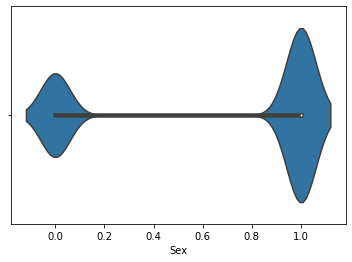

In [ ]:
#Violin plot of the column
sns.violinplot(df_new['Sex'])

<AxesSubplot:xlabel='Capital_gain', ylabel='Density'>

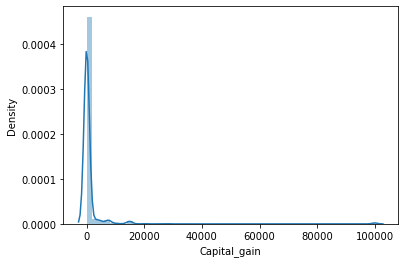

In [ ]:
#Density plot for the column
sns.distplot(df_new['Capital_gain'])

<AxesSubplot:xlabel='Capital_gain'>

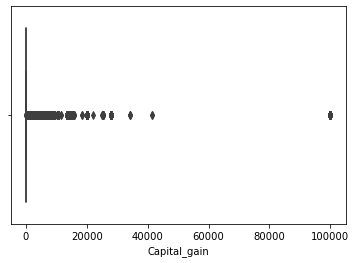

In [ ]:
#Box plot for the column
sns.boxplot(df_new['Capital_gain'])

<AxesSubplot:xlabel='Capital_loss', ylabel='Density'>

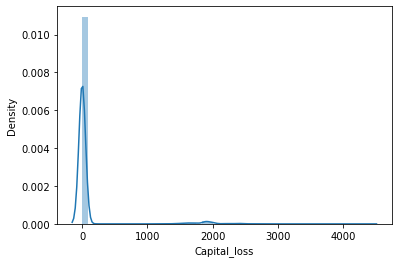

In [ ]:
#Density plot for the column
sns.distplot(df_new['Capital_loss'])

<AxesSubplot:xlabel='Capital_loss'>

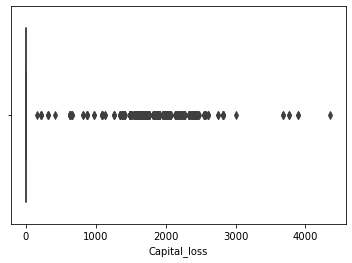

In [ ]:
#Box plot for the column
sns.boxplot(df_new['Capital_loss'])

<AxesSubplot:xlabel='Hours_per_week', ylabel='Density'>

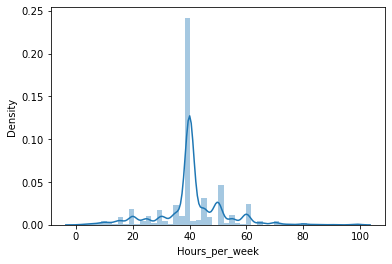

In [ ]:
#Density plot for the column
sns.distplot(df_new['Hours_per_week'])

<AxesSubplot:xlabel='Hours_per_week'>

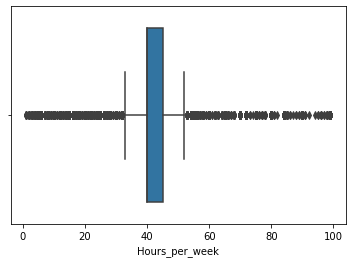

In [ ]:
#Box plot for the column
sns.boxplot(df_new['Hours_per_week'])

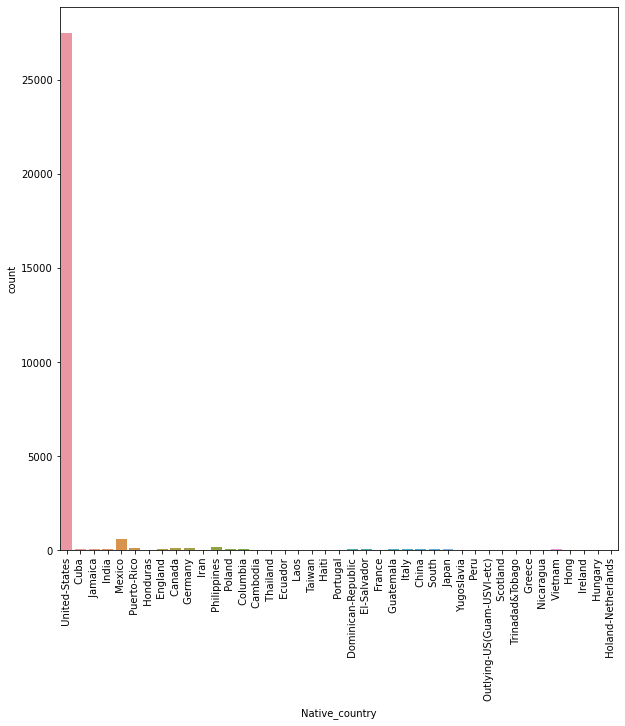

In [ ]:
#Count plot for the column
plt.figure(figsize=(10,10))
sns.countplot(df_new['Native_country'])
plt.xticks(rotation=90)
plt.show()

Encoding the data to numerical features

In [ ]:
df_new['Native_country'] = le.fit_transform(df_new['Native_country'])

<AxesSubplot:xlabel='Native_country'>

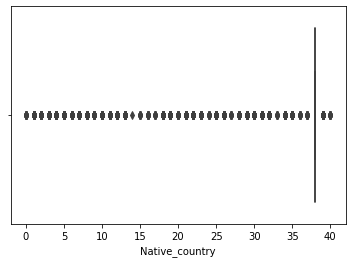

In [ ]:
#Box plot for the column
sns.boxplot(df_new['Native_country'])

# Correlation

Now, since all the data has been transformed into numeric values. Let us check for the correlation to the target column

In [ ]:
df_new.corr() #Correlation matrix

,Age,Workclass,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
Age,1.000000,0.080548,-0.076511,0.043525,-0.276378,-0.005680,-0.246456,0.023373,0.081992,0.080154,0.060166,0.101599,-0.001905,0.242000
Workclass,0.080548,1.000000,-0.032395,0.037729,-0.034338,0.015719,-0.067401,0.044700,0.074917,0.035340,0.007226,0.050738,0.007644,0.018103
Fnlwgt,-0.076511,-0.032395,1.000000,-0.044954,0.032197,0.000152,0.009289,-0.023882,0.025387,0.000427,-0.009757,-0.022889,-0.066709,-0.008978
Education_num,0.043525,0.037729,-0.044954,1.000000,-0.063457,0.087778,-0.091928,0.032791,0.006131,0.124413,0.079656,0.152528,0.091547,0.335317
Marital_status,-0.276378,-0.034338,0.032197,-0.063457,1.000000,0.022702,0.177975,-0.068641,-0.119837,-0.042424,-0.035197,-0.189004,-0.025911,-0.193504
Occupation,-0.005680,0.015719,0.000152,0.087778,0.022702,1.000000,-0.053742,0.000736,0.062350,0.022170,0.014597,0.018362,-0.003470,0.051551
Relationship,-0.246456,-0.067401,0.009289,-0.091928,0.177975,-0.053742,1.000000,-0.117140,-0.584876,-0.058258,-0.063569,-0.257851,-0.010806,-0.251009
Race,0.023373,0.044700,-0.023882,0.032791,-0.068641,0.000736,-0.117140,1.000000,0.089178,0.014351,0.023520,0.048533,0.124511,0.071666
Sex,0.081992,0.074917,0.025387,0.006131,-0.119837,0.062350,-0.584876,0.089178,1.000000,0.048811,0.047017,0.231272,0.000612,0.216715
Capital_gain,0.080154,0.035340,0.000427,0.124413,-0.042424,0.022170,-0.058258,0.014351,0.048811,1.000000,-0.032228,0.080432,0.008529,0.221200


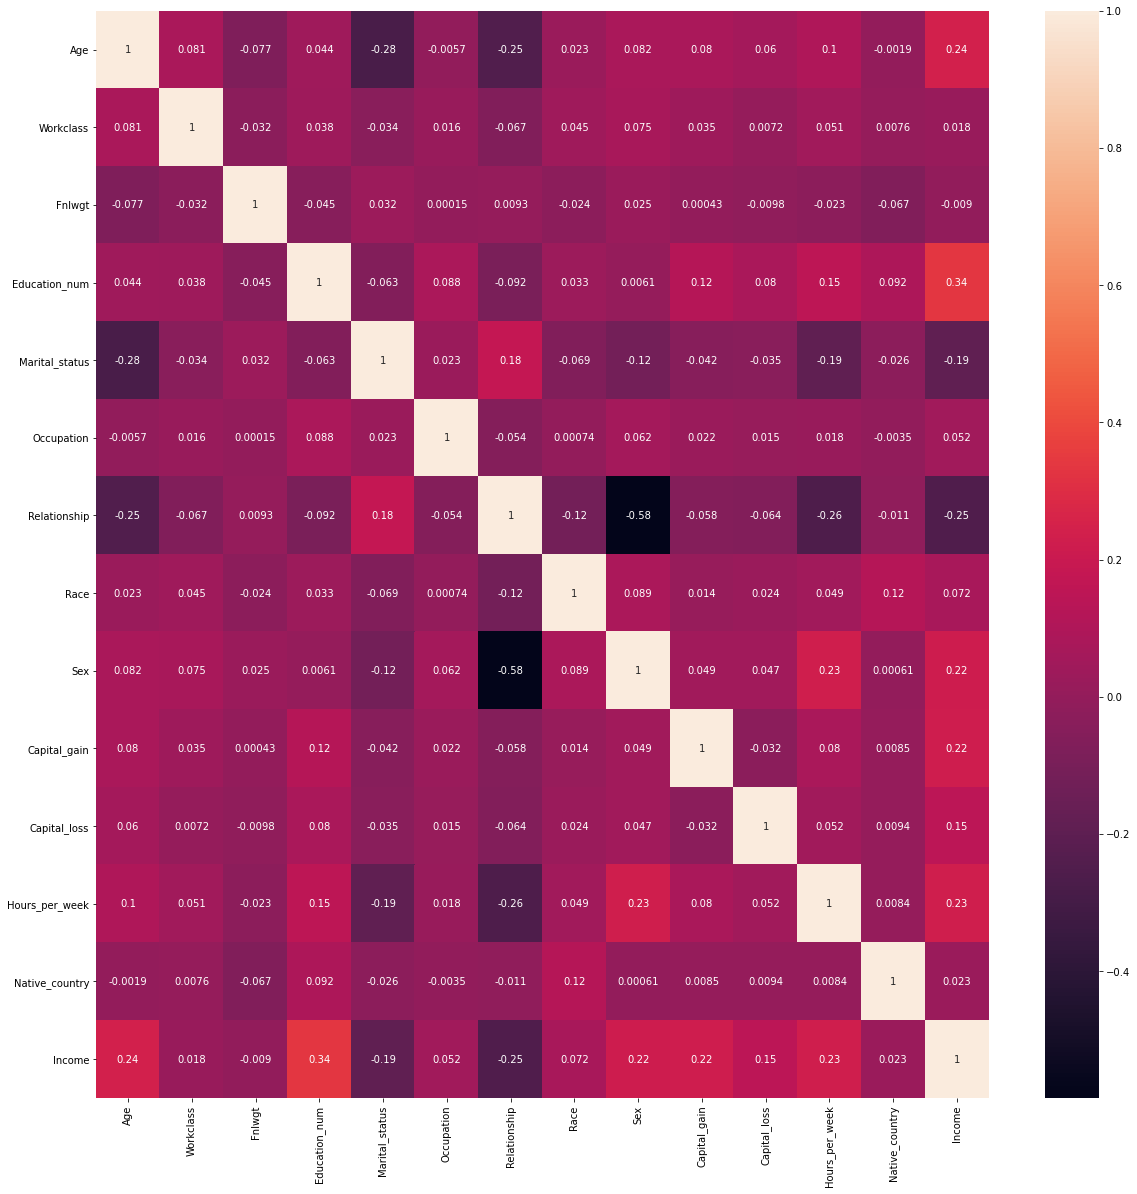

In [ ]:
#Visualization for correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(df_new.corr(),annot=True)
plt.show()

In [ ]:
#Correlation wrt target column
df_new.corr()['Income'].sort_values()

Relationship     -0.251009
Marital_status   -0.193504
Fnlwgt           -0.008978
Workclass         0.018103
Native_country    0.023273
Occupation        0.051551
Race              0.071666
Capital_loss      0.150050
Sex               0.216715
Capital_gain      0.221200
Hours_per_week    0.229480
Age               0.242000
Education_num     0.335317
Income            1.000000
Name: Income, dtype: float64

The correlation to the target variable is balanced with Education_num having the highest correlation

# Outliers

In [ ]:
z = np.abs(zscore(df_new))

We take a zscore threshold of range(-3,3)

In [ ]:
df_new = df_new[(z<3).all(axis=1)]

In [ ]:
print("Percentage loss of data:\t", ((z.shape[0]-df_new.shape[0])*100)/z.shape[0], "%")

Percentage loss of data:	 14.595006796856868 %


# Skewness

Now, we split the data into feature and target columns

In [ ]:
x = df_new.drop(columns='Income')
y = df_new['Income']

We treat for skewness to the feature variables

In [ ]:
x.skew()

Age                0.443409
Workclass          1.183942
Fnlwgt             0.627870
Education_num     -0.135184
Marital_status    -0.039587
Occupation         0.122604
Relationship       0.788039
Race              -2.641835
Sex               -0.719849
Capital_gain       4.844071
Capital_loss      28.905177
Hours_per_week    -0.285632
Native_country    -5.337123
dtype: float64

In [ ]:
k = []
for i in x.columns:
    k.append(np.abs(x[i].skew()))

b=0
for i in x.columns:
    if k[b]>0.5:
        x[i] = np.sqrt(x[i])
    b+=1

In [ ]:
x.skew()

Age                0.443409
Workclass         -1.224362
Fnlwgt            -0.110798
Education_num     -0.135184
Marital_status    -0.039587
Occupation         0.122604
Relationship       0.153242
Race              -2.649532
Sex               -0.719849
Capital_gain       3.640231
Capital_loss      26.003379
Hours_per_week    -0.285632
Native_country    -5.433095
dtype: float64

# Best Random State

In [ ]:
maxRS = 0
maxAcc = 0
for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=i)
    lr = LogisticRegression()
    lr.fit(x_train,y_train)
    pred = lr.predict(x_test)
    acc = accuracy_score(y_test, pred)
    if acc>maxAcc:
        maxAcc = acc
        maxRS = i
print("Max accuracy: \t", maxAcc)
print("Random State: \t", maxRS)

Max accuracy: 	 0.8371506211180124
Random State: 	 59


Now since we got the best random state for data modelling, we create the test train models

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=maxRS)

# Upsampling the Training Dataset

In [ ]:
U = pd.concat([x_train,y_train], axis=1) #Joining the train dataset

In [ ]:
more = U[U['Income']==0]
less = U[U['Income']==1]

In [ ]:
upsample = resample(less,
                    replace=True, #Sample with replacement
                    n_samples=len(more), #matching with the majority class
                    random_state=maxRS) #Reproductible results

In [ ]:
new_U = pd.concat([more,upsample])

In [ ]:
new_U['Income'].value_counts()

0    15820
1    15820
Name: Income, dtype: int64

In [ ]:
x_train = new_U.drop(columns='Income')
y_train = new_U['Income']

# Model Predictions

Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
pred = lr.predict(x_test)
print("Accuracy: \t", accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 	 77.44565217391305
[[3045  917]
 [ 245  945]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      3962
           1       0.51      0.79      0.62      1190

    accuracy                           0.77      5152
   macro avg       0.72      0.78      0.73      5152
weighted avg       0.83      0.77      0.79      5152



K-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
pred = knn.predict(x_test)
print("Accuracy: \t", accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 	 70.3222049689441
[[2792 1170]
 [ 359  831]]
              precision    recall  f1-score   support

           0       0.89      0.70      0.79      3962
           1       0.42      0.70      0.52      1190

    accuracy                           0.70      5152
   macro avg       0.65      0.70      0.65      5152
weighted avg       0.78      0.70      0.72      5152



Support Vector Classifier

In [ ]:
svc = SVC()
svc.fit(x_train, y_train)
pred = svc.predict(x_test)
print("Accuracy: \t", accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 	 73.91304347826086
[[2931 1031]
 [ 313  877]]
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      3962
           1       0.46      0.74      0.57      1190

    accuracy                           0.74      5152
   macro avg       0.68      0.74      0.69      5152
weighted avg       0.80      0.74      0.76      5152



Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
pred = dt.predict(x_test)
print("Accuracy: \t", accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 	 80.39596273291926
[[3459  503]
 [ 507  683]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3962
           1       0.58      0.57      0.57      1190

    accuracy                           0.80      5152
   macro avg       0.72      0.72      0.72      5152
weighted avg       0.80      0.80      0.80      5152



Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
print("Accuracy: \t", accuracy_score(y_test,pred)*100)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 	 84.49145962732919
[[3596  366]
 [ 433  757]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3962
           1       0.67      0.64      0.65      1190

    accuracy                           0.84      5152
   macro avg       0.78      0.77      0.78      5152
weighted avg       0.84      0.84      0.84      5152



We see that the Random Forest Classifier gives the most efficiency

# Cross Validation

In [ ]:
scr1 = cross_val_score(lr, x, y, cv=5)
print("Cross validation score of Logistic Regression is: \t", scr1.mean())

Cross validation score of Logistic Regression is: 	 0.8286035259992935


In [ ]:
scr2 = cross_val_score(knn, x, y, cv=5)
print("Cross validation score of KNN is: \t", scr2.mean())

Cross validation score of KNN is: 	 0.7954113791448563


In [ ]:
scr3 = cross_val_score(svc, x, y, cv=5)
print("Cross validation score of SVC is: \t", scr3.mean())

Cross validation score of SVC is: 	 0.795333822293446


In [ ]:
scr4 = cross_val_score(dt, x, y, cv=5)
print("Cross validation score of Decision Tree is: \t", scr4.mean())

Cross validation score of Decision Tree is: 	 0.7995264593138159


In [ ]:
scr5 = cross_val_score(rf, x, y, cv=5)
print("Cross validation score of Random Forest is: \t", scr5.mean())

Cross validation score of Random Forest is: 	 0.8503436210902786


We can see that 'Random Forest' performs the best among others

# Hyper Parameter Tuning

In [ ]:
GridSearchCV.get_params(rf) #Getting the parameters for RandonForrestClassifier

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Adding parameters to tune the model to best efficiency
parameters = {'bootstrap': [True,False],
              'max_depth': [10, 20, 30, None],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 5],
              'n_estimators': [200, 400]}

In [ ]:
gcv = GridSearchCV(rf, parameters, cv=5, scoring='accuracy')

In [ ]:
#Fitting the parameters
gcv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [200, 400]},
             scoring='accuracy')

In [ ]:
#Finding the best score
gcv.best_score_

0.9423198482932996

In [ ]:
#Finding the best parameters
gcv.best_params_

{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
gcv_pred = gcv.best_estimator_.predict(x_test)
accuracy_score(y_test,gcv_pred)

0.8445263975155279

We see the accuracy IS 84%

# ROC AUC Plot

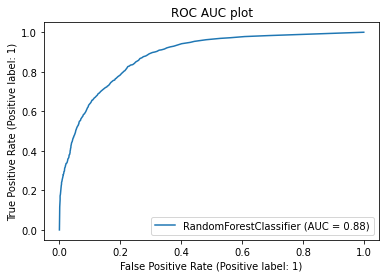

In [ ]:
plot_roc_curve(gcv.best_estimator_,x_test,y_test)
plt.title("ROC AUC plot")
plt.show()

The AUC score of 88% is very good

# Saving the best model

In [ ]:
joblib.dump(gcv.best_estimator_,"census_income.pkl")

['census_income.pkl']